In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import scipy.sparse as sparse
from scipy.special import logit, expit
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow
from tqdm import tqdm

In [3]:
import KECENI

In [4]:
n_process = 32

# load data

In [5]:
data_dir = 'data'

In [6]:
i_sim = 0

In [7]:
data_network = pd.read_feather('%s/network.feather'%(data_dir))
data_latent = pd.read_feather('%s/latent.feather'%data_dir)
data_feature = pd.read_feather('%s/feature_%.3d.feather'%(data_dir, i_sim))

In [8]:
data_network

,row,col
0,1,2311
1,1,3144
2,1,3568
3,1,3603
4,2,2146
...,...,...
9917,3999,3227
9918,4000,279
9919,4000,2085
9920,4000,3306


In [9]:
data_feature

,X1,X2,X3,W1,W2,W3,p,T,m,Y
0,0,1,1,-0.25,0.25,-0.25,0.500000,1,0.622459,0
1,0,0,1,0.25,-0.25,-0.25,0.222700,1,0.904651,1
2,1,0,0,-0.25,0.25,-0.25,0.544525,0,0.320821,1
3,0,1,1,-0.25,0.25,-0.25,0.651355,1,0.407333,1
4,1,1,1,0.25,0.25,0.25,0.500000,1,0.622459,1
...,...,...,...,...,...,...,...,...,...,...
3995,0,1,0,-0.25,-0.25,0.25,0.500000,1,0.622459,0
3996,1,1,0,0.25,-0.25,-0.25,0.500000,0,0.377541,0
3997,0,1,0,-0.25,-0.25,0.25,0.222700,0,0.777300,1
3998,0,0,0,0.25,0.25,0.25,0.777300,1,0.222700,0


In [10]:
n_node = len(data_latent); n_node

4000

In [11]:
len(data_network)

9922

In [12]:
Adj = sparse.csr_matrix((
    np.full(len(data_network), True), 
    (np.array(data_network.row)-1, np.array(data_network.col)-1)
)).toarray()

In [13]:
Zs = data_latent.values.astype(float)
G = KECENI.Graph(Adj, Zs=Zs)

In [14]:
Ys = data_feature.iloc[:,9].values
Ts = data_feature.iloc[:,7].values
Xs = data_feature.iloc[:,0:2].values

In [15]:
data = KECENI.Data(Ys, Ts, Xs.astype(float), G)

# hyperparameters

In [16]:
from hyperparams import GW

In [17]:
alpha_T = 1/np.std(Ts)
alpha_X = 1/np.std(Xs)/Xs.shape[-1]

In [18]:
GW_data = GW(alpha_T, alpha_X)
delta = GW_data.delta

# counterfactual of interest

In [19]:
i0s = np.arange(0,n_node,10)

In [20]:
T0s_0 = Ts.copy(); T0s_0[:] = 0
T0s_1 = Ts.copy(); T0s_1[:] = 1

In [21]:
T0s = np.stack([T0s_0, T0s_1], 0)

# groundtruth

In [22]:
from KECENI.RegressionModel import FittedRegressionModel
from KECENI.PropensityModel import FittedPropensityModel
from KECENI.CovariateModel import FittedCovariateModel

In [23]:
from true_model import *

In [24]:
true_model = KECENI.Model(
    FittedRegressionModel(mu),
    FittedPropensityModel(pi),
    FittedCovariateModel(rX),
    delta
)

In [25]:
true_fit = true_model.fit(data, n_X=None)

In [26]:
result_true = true_fit.G_estimate(
    i0s[:,None], T0s, n_X=10000, tqdm=tqdm
)

i0: 100%|██████████| 800/800 [00:07<00:00, 101.34it/s]


In [27]:
YTRs_0, YTRs_1 = np.moveaxis(result_true, -1, 0)

In [28]:
EYTR_0 = np.mean(YTRs_0)
EYTR_1 = np.mean(YTRs_1)
EYTR_d = EYTR_1 - EYTR_0

In [29]:
EYTR_1, EYTR_0, EYTR_d

(0.5939215812039516, 0.40601784378409334, 0.18790373741985822)

# estimation

In [30]:
from KECENI.RegressionModel import KernelRegressionModel
from KECENI.PropensityModel import KernelIIDPropensityModel
from KECENI.CovariateModel import IIDCovariateModel

In [31]:
delta_mu = GW_data.delta_mu
delta_pi = GW_data.delta_pi

## - cross-validation

### * outcome regression model

In [36]:
lamdas = np.linspace(0, 20, 21)[1:]

In [37]:
mu_fit = KernelRegressionModel(delta_mu).fit(data)

In [38]:
_, mus_cv = mu_fit.loo_cv(lamdas, tqdm=tqdm, n_process=32)

j: 100%|██████████| 4000/4000 [05:09<00:00, 12.93it/s]


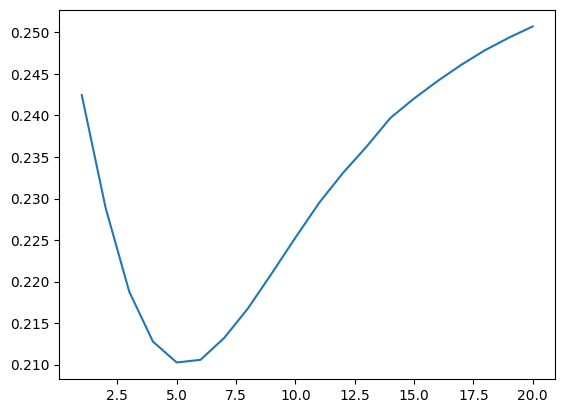

In [39]:
plt.plot(lamdas, np.mean((mus_cv-Ys)**2, -1))

In [40]:
id_mcv = np.argmin(np.mean((mus_cv-Ys)**2, -1))
lamda_mu = lamdas[id_mcv]

In [41]:
id_mcv, lamda_mu

(4, 5.0)

#### check

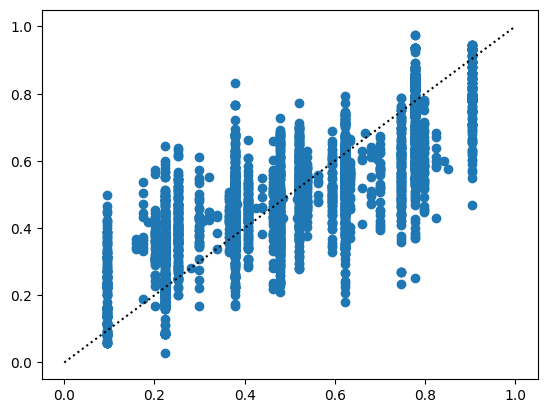

In [42]:
plt.scatter(data_feature.m.values, mus_cv[id_mcv])
plt.plot([0, 1], [0, 1], color='black', linestyle=':')

### * propensity score model

In [43]:
lamdas = np.linspace(0, 20, 21)[1:]

In [44]:
pi_fit = KernelIIDPropensityModel(delta_pi).fit(data)

In [45]:
_, pis_cv = pi_fit.loo_cv(lamdas, tqdm=tqdm, n_process=32)

j: 100%|██████████| 4000/4000 [11:32<00:00,  5.78it/s]


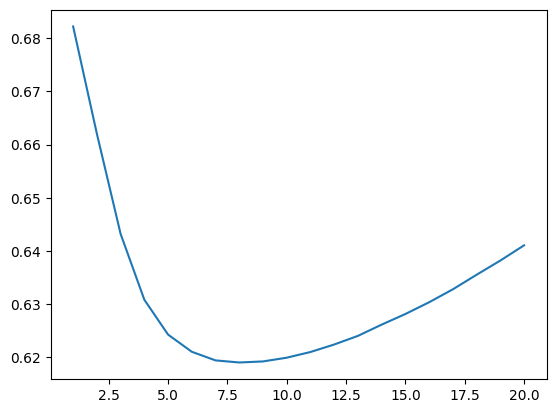

In [46]:
plt.plot(lamdas, np.mean(-np.log(np.abs(pis_cv + Ts - 1)), -1))

In [47]:
id_pcv = np.argmin(np.mean(-np.log(np.abs(pis_cv + Ts - 1)), -1))
lamda_pi = lamdas[id_pcv]

In [48]:
id_pcv, lamda_pi

(7, 8.0)

#### check

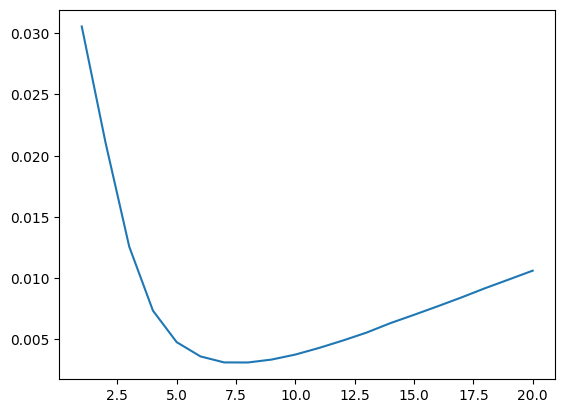

In [51]:
plt.plot(lamdas, np.mean((pis_cv - data_feature.p.values)**2, -1))

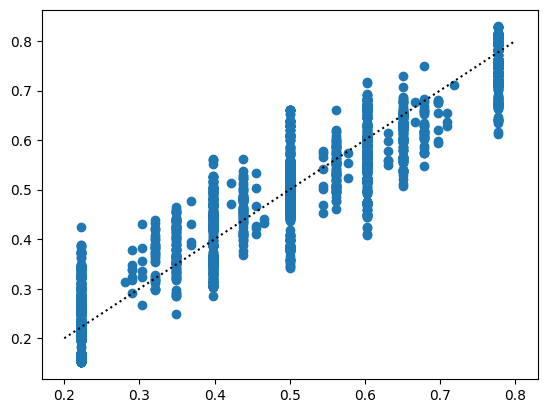

In [52]:
plt.scatter(data_feature.p.values, pis_cv[id_pcv])
plt.plot([0.2,0.8], [0.2,0.8], color='black', linestyle=':')

### * hyperaparameter for KECENI

In [32]:
lamda_mu = 5.0
lamda_pi = 8.0

In [33]:
keceni_model = KECENI.Model(
    KernelRegressionModel(delta_mu, lamda=lamda_mu),
    KernelIIDPropensityModel(delta_pi, lamda=lamda_pi),
    IIDCovariateModel(),
    delta
)

In [34]:
keceni_fit = keceni_model.fit(data, tqdm=tqdm, n_X=10, n_process=n_process)

fit: 100%|██████████| 4000/4000 [1:18:30<00:00,  1.18s/it]


In [35]:
lamdas = np.linspace(0, 20, 21)[1:]

In [39]:
result_cv = keceni_fit.cv(
    i0s=i0s, tqdm=tqdm
)

cv: 100%|██████████| 4000/4000 [01:15<00:00, 52.89it/s]


In [40]:
xs_cv, xhs_cv = result_cv.xs_xhs(lamdas)

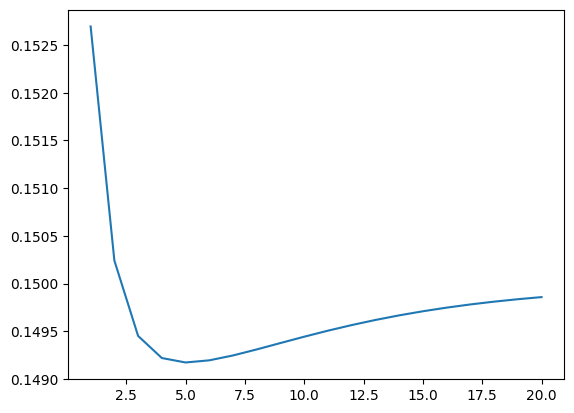

In [42]:
plt.plot(lamdas, np.mean((xs_cv-xhs_cv)**2, -1))

In [43]:
id_cv = np.argmin(np.mean((xs_cv-xhs_cv)**2, -1))
id_cv

4

In [44]:
# id_cv = 1

In [45]:
lamdas[id_cv]

5.0

## - G estimate

In [46]:
result_G = keceni_fit.G_estimate(
    i0s[:,None], T0s, n_X=100,
    n_process=n_process, tqdm=tqdm, level_tqdm=0
)

i0: 100%|██████████| 800/800 [28:30<00:00,  2.14s/it] 


In [47]:
YGs_0, YGs_1 = np.moveaxis(result_G, -1, 0)
YGs_d = YGs_1 - YGs_0

In [48]:
EYG_0 = np.mean(YGs_0)
EYG_1 = np.mean(YGs_1)
EYG_d = EYG_1 - EYG_0

In [49]:
EYG_0, EYG_1, EYG_d

(0.4709319185416625, 0.5518422998854581, 0.08091038134379558)

(array([  7.,  27.,  63., 103.,  84.,  48.,  21.,  14.,  18.,  15.]),
 array([-0.01831964,  0.00443623,  0.0271921 ,  0.04994796,  0.07270383,
         0.0954597 ,  0.11821557,  0.14097143,  0.1637273 ,  0.18648317,
         0.20923904]),
 <BarContainer object of 10 artists>)

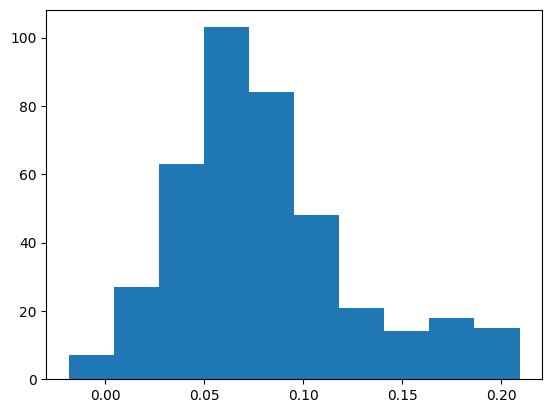

In [50]:
plt.hist(YGs_d)

## - kernel EIF

In [51]:
result_AIPW = keceni_fit.kernel_AIPW(
    i0s[:,None], T0s, tqdm=tqdm
)

AIPW: 100%|██████████| 4000/4000 [02:26<00:00, 27.34it/s]


In [52]:
YDRs_0, YDRs_1 = np.moveaxis(result_AIPW.est(lamdas)[id_cv], -1, 0)
YDRs_d = YDRs_1 - YDRs_0

In [53]:
EYDR_0 = np.mean(YDRs_0)
EYDR_1 = np.mean(YDRs_1)
EYDR_d = EYDR_1 - EYDR_0

In [54]:
EYDR_0, EYDR_1, EYDR_d

(0.4250881481145787, 0.603786858369631, 0.1786987102550523)

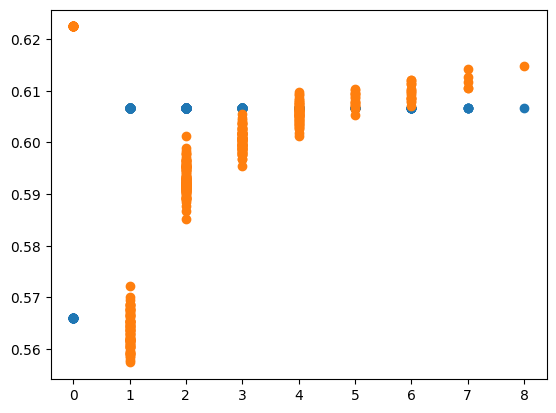

In [55]:
plt.scatter(np.sum(Adj[i0s], 1), YDRs_1)
plt.scatter(np.sum(Adj[i0s], 1), YTRs_1)

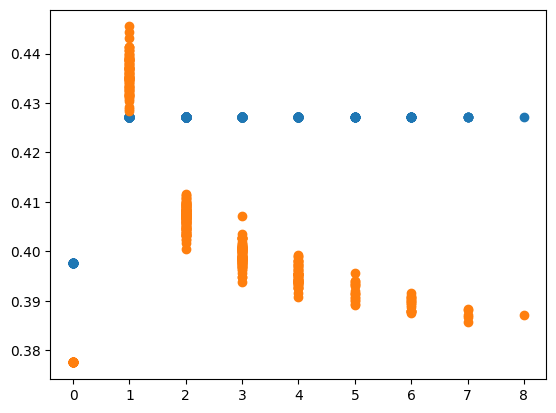

In [56]:
plt.scatter(np.sum(Adj[i0s], 1), YDRs_0)
plt.scatter(np.sum(Adj[i0s], 1), YTRs_0)